In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns

from scipy.optimize import minimize

In [3]:
data = pd.read_csv('Take 2019-11-22 04.01.54 PM.csv')
data = data.rename(columns={'Unnamed: 0': 'Frame',
                            'Unnamed: 1': 'Time',
                            'cap2': 'a',
                            'cap2.1': 'b',
                            'cap2.2': 'c', 
                            'cap2.3': 'd',
                            'cap2.4': 'x',
                            'cap2.5': 'y',
                            'cap2.6': 'z',
                            'cap2.7': 'Error Per Marker'})
data = data.set_index('Frame')
data = data.iloc[2:, :8]
data = data.astype(float)
data.index = data.index.astype(int)
data.head()

,Time,a,b,c,d,x,y,z
Frame,,,,,,,,
1000,8.333333,0.111165,0.916884,-0.195173,0.329961,3700.165527,1072.775757,3542.805908
1001,8.341667,0.113267,0.917423,-0.195142,0.327757,3697.688477,1073.941528,3544.438721
1002,8.350000,0.115142,0.917377,-0.194097,0.327853,3700.593506,1074.788696,3542.902588
1003,8.358333,0.111132,0.916977,-0.194403,0.330166,3701.040039,1072.582031,3541.783203
1004,8.366667,0.109814,0.916527,-0.194841,0.331596,3701.489990,1072.662354,3539.877441


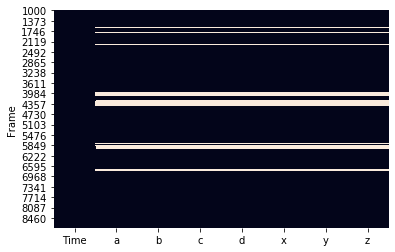

In [4]:
sns.heatmap(data.isnull(), cbar=False)

In [5]:
d1 = data.diff(1)
data['dx'] = d1.x / d1.Time
data['dy'] = d1.y / d1.Time
data['dz'] = d1.z / d1.Time
data.head()

,Time,a,b,c,d,x,y,z,dx,dy,dz
Frame,,,,,,,,,,,
1000,8.333333,0.111165,0.916884,-0.195173,0.329961,3700.165527,1072.775757,3542.805908,NaN,NaN,NaN
1001,8.341667,0.113267,0.917423,-0.195142,0.327757,3697.688477,1073.941528,3544.438721,-297.222222,139.881329,195.921886
1002,8.350000,0.115142,0.917377,-0.194097,0.327853,3700.593506,1074.788696,3542.902588,348.617425,101.664227,-184.343334
1003,8.358333,0.111132,0.916977,-0.194403,0.330166,3701.040039,1072.582031,3541.783203,53.586103,-264.810392,-134.331573
1004,8.366667,0.109814,0.916527,-0.194841,0.331596,3701.489990,1072.662354,3539.877441,53.989801,9.637989,-228.673146


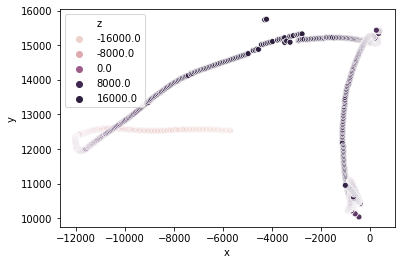

In [6]:
sns.scatterplot(x='x', y='y', hue='z', data=data.loc[2500:3500])

## Model

$ \dot{x}_i = \beta_0 x_i + \beta_1 \dot{x}_{i-1} + \beta_2 y_i + \beta_3 \dot{y}_{i-1} $

$ \dot{y}_i = \beta_4 x_i + \beta_5 \dot{x}_{i-1} + \beta_6 y_i + \beta_7 \dot{y}_{i-1} $

$ x_{i+1} = \dot{x}_i dt $

$ y_{i+1} = \dot{y}_i dt $

### Estimator

$ \hat{\beta} = \min_{\beta \in \mathbf{R}^8} \overline{\sqrt{(\hat{X} - X)^2 + (\hat{Y} - Y)^2}} $

In [7]:
def markov1(x1, dx0, y1, dy0, dt, coef):
    dx1 = coef[0] * x1 + coef[1] * dx0 + coef[2] * y1 + coef[3] * dy0
    dy1 = coef[4] * x1 + coef[5] * dx0 + coef[6] * y1 + coef[7] * dy0
    x2 = x1 + dx1 * dt
    y2 = y1 + dy1 * dt
    return x2, dx1, y2, dx1

In [8]:
# def euclidean(x_true, dx_true, y_true, dy_true, x_pred, dx_pred, y_pred, dy_pred, a, b):
#     return a * np.sqrt((x_true - x_pred) ** 2 + (y_true - y_pred) ** 2)\
#            + b * np.sqrt((dx_true - dx_pred) ** 2 + (dy_true - dy_pred) ** 2)

In [9]:
def euclidean(x_true, y_true, x_pred, y_pred):
    return np.sqrt((x_true - x_pred) ** 2 + (y_true - y_pred) ** 2)

In [10]:
## Training
df = data.loc[2500:3500]
df['dx_0'] = df.dx.shift(1)
df['dy_0'] = df.dy.shift(1)
df['x_2'] = df.x.shift(-1)
df['y_2'] = df.y.shift(-1)
df['dt'] = df.Time.shift(-1) - df.Time
df = df.dropna()
df.head()

,Time,a,b,c,d,x,y,z,dx,dy,dz,dx_0,dy_0,x_2,y_2,dt
Frame,,,,,,,,,,,,,,,,
2501,20.841667,0.094741,0.982244,-0.161868,0.004463,-5756.597168,12535.717773,-11668.291992,-6088.751140,596.553756,2418.908087,-6476.098884,43.947078,-5811.610352,12537.488281,0.008333
2502,20.850000,0.090559,0.982212,-0.164466,0.003022,-5811.610352,12537.488281,-11646.528320,-6601.846154,212.469459,2611.745110,-6088.751140,596.553756,-5867.389160,12544.687500,0.008333
2503,20.858333,0.091619,0.981543,-0.167851,0.002200,-5867.389160,12544.687500,-11624.177734,-6693.724709,863.940838,2682.177607,-6601.846154,212.469459,-5922.932617,12548.831055,0.008334
2504,20.866667,0.093344,0.981866,-0.165003,0.000930,-5922.932617,12548.831055,-11607.237305,-6664.681665,497.186825,2032.688865,-6693.724709,863.940838,-5970.652344,12543.473633,0.008333
2505,20.875000,0.084583,0.983265,-0.161262,-0.005553,-5970.652344,12543.473633,-11583.413086,-5726.596304,-642.916357,2859.020641,-6664.681665,497.186825,-6024.270020,12547.648438,0.008333


In [11]:
## Model
f = lambda coef, df: np.mean(df.T.apply(lambda x: (markov1(x['x'], x['dx_0'], x['y'], x['dy_0'], x['dt'], coef), x['x_2'], x['y_2'])).apply(lambda x: euclidean(x[1], x[2], x[0][0], x[0][2])))

In [12]:
## Baseline
f([0.1 for i in range(8)], df)

35.736328516196274

In [13]:
## Fitting
results = minimize(f, [0.1 for i in range(8)], args=df)

In [14]:
coef_hat = results.x
f(coef_hat, df)

15.034439231314657

In [15]:
## Test
df = data.loc[3500:4500]
df['dx_0'] = df.dx.shift(1)
df['dy_0'] = df.dy.shift(1)
df['x_2'] = df.x.shift(-1)
df['y_2'] = df.y.shift(-1)
df['dt'] = df.Time.shift(-1) - df.Time
df = df.dropna()
df.head()

,Time,a,b,c,d,x,y,z,dx,dy,dz,dx_0,dy_0,x_2,y_2,dt
Frame,,,,,,,,,,,,,,,,
3501,29.175000,-0.142740,-0.178276,0.074306,-0.970732,-1032.438965,10967.594727,8697.565430,-2975.465739,1677.723389,4955.354494,-2186.521838,1500.348692,-1053.174927,10980.178711,0.008333
3502,29.183333,-0.141589,-0.172781,0.074888,-0.971849,-1053.174927,10980.178711,8733.990234,-2488.414977,1510.138486,4371.151326,-2975.465739,1677.723389,-1075.149658,10990.411133,0.008334
3503,29.191667,-0.139703,-0.169150,0.076362,-0.972646,-1075.149658,10990.411133,8768.397461,-2636.756779,1227.792417,4128.536957,-2488.414977,1510.138486,-1099.127319,11001.691406,0.008333
3504,29.200000,-0.139605,-0.163501,0.078144,-0.973484,-1099.127319,11001.691406,8802.968750,-2877.434417,1353.686907,4148.720629,-2636.756779,1227.792417,-1120.536987,11011.668945,0.008333
3505,29.208333,-0.138680,-0.157773,0.076757,-0.974671,-1120.536987,11011.668945,8838.036133,-2569.262931,1197.352574,4208.254290,-2877.434417,1353.686907,-1147.675659,11021.288086,0.008334


In [16]:
f([0.1 for i in range(8)], df)

50.77794203771443

In [17]:
f(coef_hat, df)

37.31854001138506